In [2]:
# Cell 1 – set up paths and load the 100-row QA file

from pathlib import Path
import pandas as pd

# Point to project root manually (adjust if your path is slightly different)
PROJECT_ROOT = Path("/Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation")

PROCESSED_DATA_DIR = PROJECT_ROOT / "data" / "processed"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("PROCESSED_DATA_DIR:", PROCESSED_DATA_DIR)

# Existing QA file with manual labels, logreg preds, and old BERT preds
qa_input_path = PROCESSED_DATA_DIR / "manual_qa_unlabeled_logreg_vs_bert.csv"
df_qa = pd.read_csv(qa_input_path)

print("\nLoaded QA data from:", qa_input_path)
print("Shape:", df_qa.shape)
print("\nColumns:", df_qa.columns.tolist())

# Quick peek
df_qa.head()

PROJECT_ROOT: /Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation
PROCESSED_DATA_DIR: /Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation/data/processed

Loaded QA data from: /Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation/data/processed/manual_qa_unlabeled_logreg_vs_bert.csv
Shape: (100, 9)

Columns: ['month', 'product_text_raw', 'product_text_norm', 'logreg_prob_fashion', 'logreg_pred', 'bert_prob_fashion', 'bert_pred', 'manual_label', 'notes']


,month,product_text_raw,product_text_norm,logreg_prob_fashion,logreg_pred,bert_prob_fashion,bert_pred,manual_label,notes
0,export_shopper=NOV-24,Coin Collection Holder for Collectors 240 Pock...,coin collection holder for collectors 240 pock...,0.680651,0,0.001190,0,0,NaN
1,export_shopper=NOV-24,Arm & Hammer Clump & Seal Platinum Multi-Cat C...,arm hammer clump seal platinum multi cat compl...,0.800665,0,0.000623,0,0,NaN
2,export_shopper=NOV-24,Contigo Kids Spill-Proof 14oz Tumbler with Str...,contigo kids spill proof 14oz tumbler with str...,0.377755,0,0.000630,0,0,NaN
3,export_shopper=NOV-24,"Coloring Markers Pen, Dual Brush Tip Marker fo...",coloring markers pen dual brush tip marker for...,0.478192,0,0.000858,0,0,NaN
4,export_shopper=NOV-24,The Walking Dead Poster TV Series Covers TWD P...,the walking dead poster tv series covers twd p...,0.516780,0,0.004182,0,0,NaN


In [3]:
import pandas as pd
import torch
import numpy as np
from pathlib import Path
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Sanity check: PROJECT_ROOT and PROCESSED_DATA_DIR should come from the first cell
print("PROJECT_ROOT:", PROJECT_ROOT)
print("PROCESSED_DATA_DIR:", PROCESSED_DATA_DIR)

qa_path = PROCESSED_DATA_DIR / "manual_qa_unlabeled_logreg_vs_bert.csv"
print("Loading QA data from:", qa_path)
df_qa = pd.read_csv(qa_path)
print("Shape:", df_qa.shape)
print("Columns:", list(df_qa.columns))

# Load weighted BERT model
model_dir = PROJECT_ROOT / "models" / "bert_fashion_weighted"
print("\nLoading weighted BERT model from:", model_dir)

tokenizer_w = AutoTokenizer.from_pretrained(model_dir)
model_w = AutoModelForSequenceClassification.from_pretrained(model_dir)

# Put model on the best available device
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model_w.to(device)
model_w.eval()

# Prepare texts
texts = df_qa["product_text_norm"].astype(str).tolist()

# Tokenize
encodings = tokenizer_w(
    texts,
    padding=True,
    truncation=True,
    max_length=64,
    return_tensors="pt",
)

encodings = {k: v.to(device) for k, v in encodings.items()}

with torch.no_grad():
    outputs = model_w(**encodings)
    logits = outputs.logits
    probs = torch.softmax(logits, dim=1).cpu().numpy()

df_qa["bert_weighted_prob_fashion"] = probs[:, 1]

# Same 0.50 threshold as before
threshold_weighted = 0.50
df_qa["bert_weighted_pred"] = (df_qa["bert_weighted_prob_fashion"] >= threshold_weighted).astype(int)

print("\nFirst 5 weighted probabilities and predictions:")
print(df_qa[["product_text_norm",
             "bert_weighted_prob_fashion",
             "bert_weighted_pred"]].head())

# Save to a NEW file so we keep the old one intact
out_path = PROCESSED_DATA_DIR / "manual_qa_unlabeled_logreg_vs_bert_weighted.csv"
df_qa.to_csv(out_path, index=False)
print("\nSaved weighted QA file to:", out_path)

/Users/ramana/anaconda3/envs/fashion-bert/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PROJECT_ROOT: /Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation
PROCESSED_DATA_DIR: /Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation/data/processed
Loading QA data from: /Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation/data/processed/manual_qa_unlabeled_logreg_vs_bert.csv
Shape: (100, 9)
Columns: ['month', 'product_text_raw', 'product_text_norm', 'logreg_prob_fashion', 'logreg_pred', 'bert_prob_fashion', 'bert_pred', 'manual_label', 'notes']

Loading weighted BERT model from: /Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation/models/bert_fashion_weighted

First 5 weighted probabilities and predictions:
                                   product_text_norm  \
0  coin collection holder for collectors 240 pock...   
1  arm hammer clump seal platinum multi cat compl...   
2  contigo kids spill proof 14oz tumbler with str...   
3  coloring markers pen dual brush ti

Loading QA data from: /Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation/data/processed/manual_qa_unlabeled_logreg_vs_bert_weighted.csv
Shape: (100, 11)
Columns: ['month', 'product_text_raw', 'product_text_norm', 'logreg_prob_fashion', 'logreg_pred', 'bert_prob_fashion', 'bert_pred', 'manual_label', 'notes', 'bert_weighted_prob_fashion', 'bert_weighted_pred']

=== Logistic baseline vs manual_label ===
Accuracy: 0.950
                 precision    recall  f1-score   support

non-fashion (0)       0.99      0.95      0.97        88
    fashion (1)       0.73      0.92      0.81        12

       accuracy                           0.95       100
      macro avg       0.86      0.94      0.89       100
   weighted avg       0.96      0.95      0.95       100


=== BERT original vs manual_label ===
Accuracy: 0.910
                 precision    recall  f1-score   support

non-fashion (0)       1.00      0.90      0.95        88
    fashion (1)       0.57      1

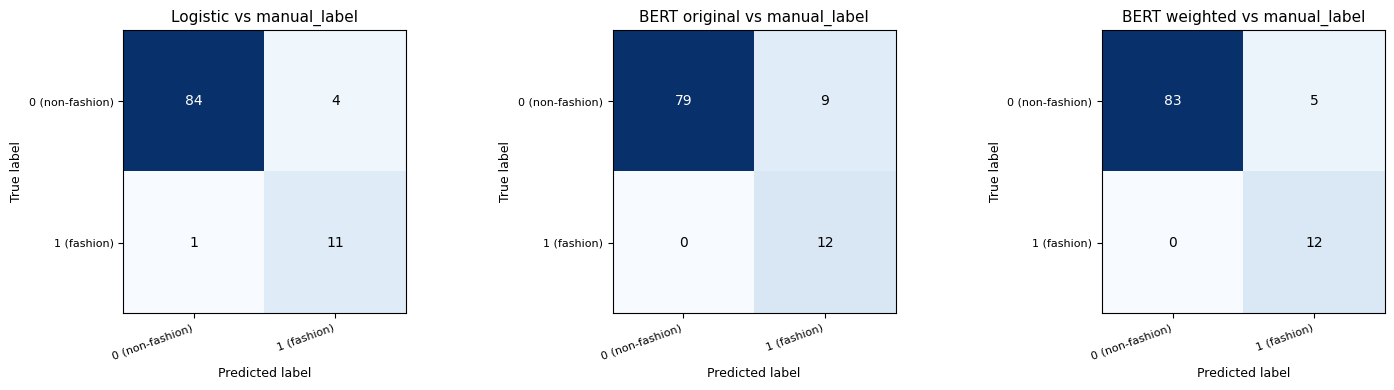

In [4]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt

# Load the weighted QA file
qa_path = PROCESSED_DATA_DIR / "manual_qa_unlabeled_logreg_vs_bert_weighted.csv"
print("Loading QA data from:", qa_path)
df = pd.read_csv(qa_path)
print("Shape:", df.shape)
print("Columns:", list(df.columns))

# True labels
y_true = df["manual_label"].astype(int).values

# Predictions from the three models
y_logreg = df["logreg_pred"].astype(int).values
y_bert = df["bert_pred"].astype(int).values
y_bert_w = df["bert_weighted_pred"].astype(int).values

def eval_and_print(name, y_pred):
    acc = accuracy_score(y_true, y_pred)
    print(f"\n=== {name} vs manual_label ===")
    print(f"Accuracy: {acc:.3f}")
    print(classification_report(
        y_true,
        y_pred,
        target_names=["non-fashion (0)", "fashion (1)"]
    ))
    return confusion_matrix(y_true, y_pred)

cm_logreg = eval_and_print("Logistic baseline", y_logreg)
cm_bert = eval_and_print("BERT original", y_bert)
cm_bert_w = eval_and_print("BERT weighted", y_bert_w)

# Plot confusion matrices side by side (no colorbar)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

cms = [cm_logreg, cm_bert, cm_bert_w]
titles = ["Logistic vs manual_label",
          "BERT original vs manual_label",
          "BERT weighted vs manual_label"]

for ax, cm, title in zip(axes, cms, titles):
    im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
    ax.set_title(title, fontsize=11)
    ax.set_xlabel("Predicted label", fontsize=9)
    ax.set_ylabel("True label", fontsize=9)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["0 (non-fashion)", "1 (fashion)"], fontsize=8, rotation=20, ha="right")
    ax.set_yticklabels(["0 (non-fashion)", "1 (fashion)"], fontsize=8)

    # Annotate counts
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j, i,
                format(cm[i, j], "d"),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=10,
            )

plt.tight_layout()
plt.show()

#### So after adding class weights, BERT basically caught up with logistic overall, and it now never misses a true fashion item in this 100-row sample. The trade-off is one extra non-fashion item being called fashion compared to logistic (5 vs 4).

### Final summary: The TF-IDF + logistic model is very conservative (95% accuracy on the unlabeled QA, almost never calling non-fashion as fashion), the original BERT is more sensitive but slightly over-labels fashion (91% on that QA), and the class-weighted BERT keeps BERT’s high recall while matching logistic’s 95% accuracy.

### Recommended usage: We will use class-weighted BERT as the primary fashion detector, and use **logistic as a secondary check—flagging cases where BERT says “fashion” but logistic says “non-fashion” for manual review or stricter downstream rules.